In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde

/data/keeling/a/xx24/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [ ]:
def calculate_metrics_and_plot(y_true, y_pred, var):
    # Calculate R2, RMSE, MAE
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - mse/np.mean((y_true - np.mean(y_true)) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))

    # Print the calculated metrics
    print(f'MSE:{mse}')
    print(f'R2: {r2}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

    # Calculate point density
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)

    # Plot y_true vs y_pred density scatter plot
    plt.figure(figsize=(8, 7))

    scatter = plt.scatter(y_true, y_pred, c=z, s=15, cmap='rainbow')

    # Create color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=17)  # Set the color bar label and fontsize
    cbar.ax.tick_params(labelsize=16)  # Set the font size for the color bar ticks

    # Plot a reference line (ideal prediction line y_true = y_pred)
    plt.plot([1e5, 1e12], [1e5, 1e12], 'r--', lw=2)
    plt.xlim(1e5, 1e12)
    plt.ylim(1e5, 1e12)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(f'Actual {var}', fontsize=17)
    plt.ylabel(f'Predicted {var}', fontsize=17)
    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, colors='black',
                    grid_color='gray', grid_alpha=0.7, labelsize=16)

    # Annotate with the metrics in the top left corner
    # metrics_text = f'R$^2$: {r2:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}'
    # plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
    #          fontsize=14,  # Adjust the font size
    #          verticalalignment='top', horizontalalignment='left',
    #          bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.5'))

    plt.title('Actual vs Predicted Scatter Plot with Density', fontsize=15)
    plt.grid(True)
    plt.show()

In [3]:
PartMC_data = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/merged_data.csv') 

splitter = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=42)
train_idxs, test_idxs = next(splitter.split(PartMC_data, groups=PartMC_data['Scenario_ID']))
train, test = PartMC_data.iloc[train_idxs], PartMC_data.iloc[test_idxs]

train_ids = set(train['Scenario_ID'])
test_ids = set(test['Scenario_ID'])

overlap_ids = train_ids.intersection(test_ids)
if overlap_ids:
    print("Error: The following Scenario_IDs are found in both training and testing sets:", overlap_ids)
else:
    print("Success: No Scenario_IDs are split between training and testing sets.")

Success: No Scenario_IDs are split between training and testing sets.


In [4]:
input_list = ['temperature','relative_humidity','so2','no2','no','nh3','co','ch3oh','ald2','anol','aone','dms','eth','hcho','isop','olei','olet','par','tol','xyl','so4','no3','cl','nh4','co3','na','ca','oin','oc','bc','h2o']
output_list = ['ccn_03']

X_train = train[input_list]
y_train = np.log1p(train[output_list].squeeze())  # log1p transformation for target
X_test = test[input_list]
y_test = np.log1p(test[output_list].squeeze())    # log1p transformation for target

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train, test_size=0.3, random_state=42)

In [7]:
# Define the best CatBoost configuration from FLAML
best_config = {
    "learning_rate": 0.06233639237958604,
    "n_estimators": 8192,
    "early_stopping_rounds": 10
}

model = CatBoostRegressor(
    **best_config,
    depth=10,          # capture more complex patterns, but monitor for overfitting.
    l2_leaf_reg=7,    # add regularization and reduce overfitting risk.
    verbose=100       
)

model.fit(X_train_final, y_train_final, eval_set=(X_val, y_val), use_best_model=True)

0:	learn: 4.1570934	test: 4.1155193	best: 4.1155193 (0)	total: 80.3ms	remaining: 10m 57s
100:	learn: 0.5700799	test: 0.5977267	best: 0.5977267 (100)	total: 1.59s	remaining: 2m 7s
200:	learn: 0.3958707	test: 0.4428487	best: 0.4428487 (200)	total: 3.02s	remaining: 2m
300:	learn: 0.2922350	test: 0.3550957	best: 0.3550957 (300)	total: 4.49s	remaining: 1m 57s
400:	learn: 0.2275742	test: 0.3053795	best: 0.3053795 (400)	total: 5.91s	remaining: 1m 54s
500:	learn: 0.1855938	test: 0.2761591	best: 0.2761591 (500)	total: 7.32s	remaining: 1m 52s
600:	learn: 0.1545556	test: 0.2551782	best: 0.2551782 (600)	total: 8.73s	remaining: 1m 50s
700:	learn: 0.1318141	test: 0.2402528	best: 0.2402528 (700)	total: 10.2s	remaining: 1m 48s
800:	learn: 0.1146181	test: 0.2299604	best: 0.2299604 (800)	total: 11.6s	remaining: 1m 47s
900:	learn: 0.1009402	test: 0.2220844	best: 0.2220844 (900)	total: 13.1s	remaining: 1m 45s
1000:	learn: 0.0903956	test: 0.2160374	best: 0.2160374 (1000)	total: 14.6s	remaining: 1m 44s
1100

In [8]:
y_pred_val_transformed = model.predict(X_val)
y_pred_val = np.expm1(y_pred_val_transformed)  # Reverse log1p
y_val_raw = np.expm1(y_val)                    # Reverse log1p

MSE:2.2162250745352748e+18
R2: 0.9881966251620873
RMSE: 1488699121.5605907
MAE: 402988695.5892659


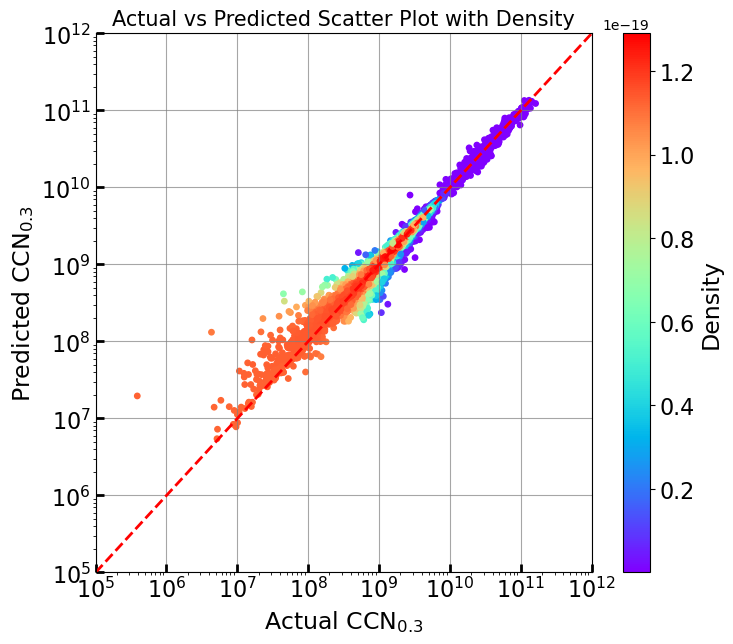

In [9]:
calculate_metrics_and_plot(y_val_raw, y_pred_val, 'CCN$_{0.3}$')

In [10]:
model.save_model("/data/keeling/a/xx24/e/proj_ml/catboost_model.cbm")

In [11]:
importances = model.get_feature_importance()
feature_names = X_train.columns
sorted_importance = sorted(dict(zip(feature_names, importances)).items(), key=lambda x: x[1], reverse=True)

In [12]:
sorted_importance

[('so4', 17.3895105511365),
 ('ch3oh', 9.712959392534206),
 ('nh4', 8.92854125784745),
 ('ald2', 7.767852589066034),
 ('so2', 7.632900607859143),
 ('aone', 6.695640431538219),
 ('oin', 5.78137395704323),
 ('hcho', 4.968701240967988),
 ('bc', 4.196521506566173),
 ('dms', 3.653252038942464),
 ('temperature', 3.328836683833703),
 ('oc', 2.7063674779290294),
 ('anol', 2.4239253802041443),
 ('relative_humidity', 2.3782392365431995),
 ('co', 1.8624751595960956),
 ('h2o', 1.5599607872024959),
 ('nh3', 1.4806346516014477),
 ('tol', 1.1348104343642893),
 ('eth', 0.9857538109197834),
 ('na', 0.9738687164997937),
 ('xyl', 0.9171014320972842),
 ('cl', 0.7850703857589634),
 ('par', 0.7461466784449295),
 ('no3', 0.4993940873074016),
 ('no2', 0.432009542032649),
 ('isop', 0.362944220161122),
 ('olet', 0.31870645603309766),
 ('no', 0.19965036251634655),
 ('olei', 0.1768509234528196),
 ('co3', 0.0),
 ('ca', 0.0)]

In [13]:
features = [x[0] for x in sorted_importance]
importances = [x[1] for x in sorted_importance]

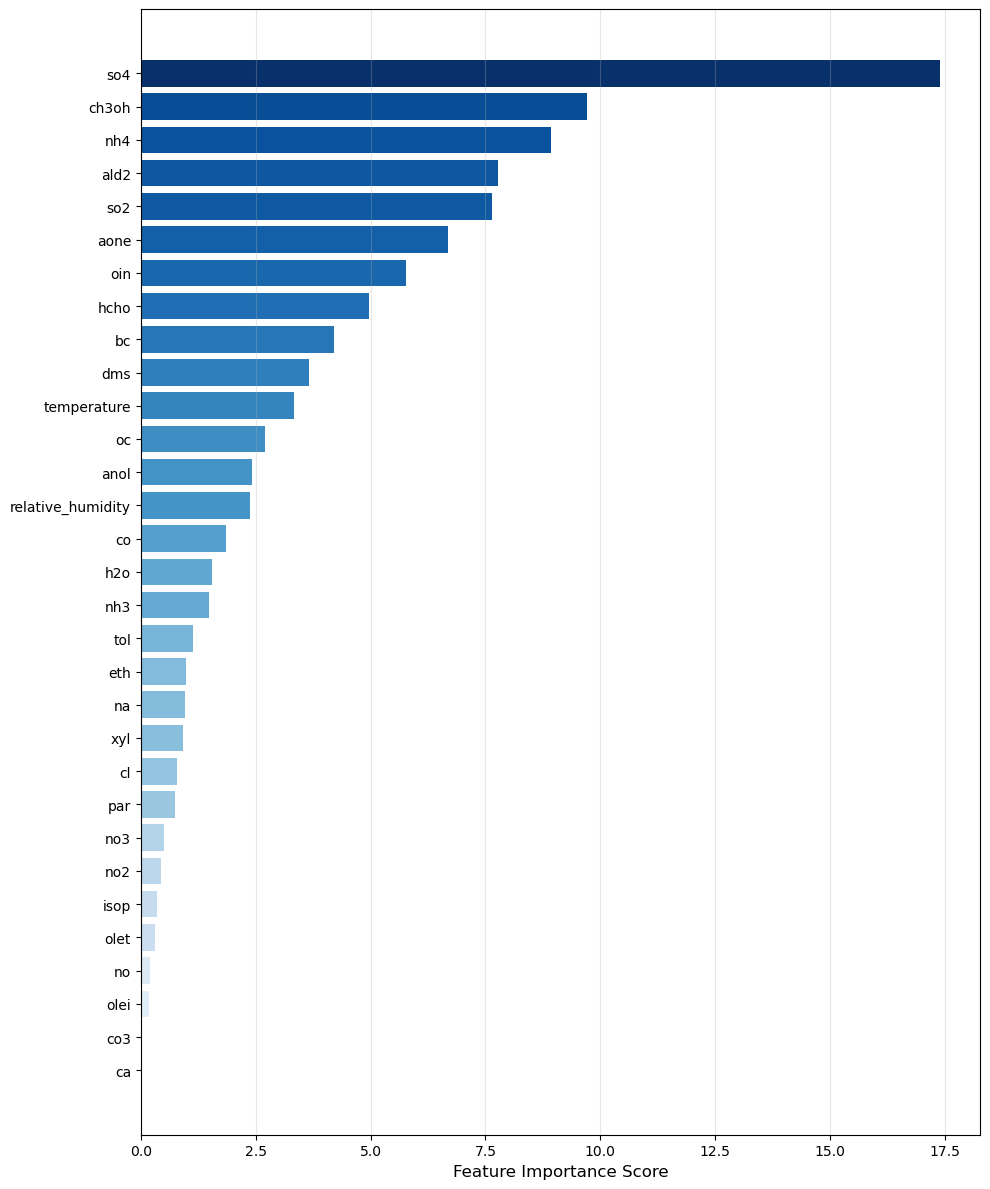

In [14]:
features = [x[0] for x in sorted_importance]
importances = [x[1] if x[1] > 0 else 1e-3 for x in sorted_importance]  # 处理0值

cmap = plt.cm.Blues
norm = LogNorm(vmin=0.1, vmax=max(importances))  # 设置动态范围

plt.figure(figsize=(10, 12))
bars = plt.barh(features, importances, 
                color=cmap(norm(importances)))

# cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), label='Log-scaled Importance')

plt.gca().invert_yaxis()
plt.xlabel('Feature Importance Score', fontsize=12)
# plt.title('Feature Importance with Smoother Color Transition', fontsize=14, pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()